In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
library(tidymodels)
install.packages("kknn")
library(kknn)
set.seed(3)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
basketball <- read_csv("https://raw.githubusercontent.com/naw333/College-Basketball-Data-Science/main/cbb.csv") 

Rows: 3523 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): TEAM, CONF, POSTSEASON, SEED
dbl (20): G, W, ADJOE, ADJDE, BARTHAG, EFG_O, EFG_D, TOR, TORD, ORB, DRB, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#The training set will be used to perform a 5-fold cross-validation to select the k value 
#that optimizes the classifier’s performance based on the accuracy of the classifier. 
#The performance of the classifier will be tested using the test set, 
#then a new set of observations for basketball teams will be classified using the trained classifier. 
#The correlation coefficient will be calculated between each predictor variable and POSTSEASON, 
#and the result of this will be visualized as a bar graph.

In [5]:
cbb_split <- initial_split(basketball, prop = 0.75, strata = POSTSEASON)
cbb_train <- training(cbb_split)
cbb_test <- testing(cbb_split)
cbb_summ <- summarize(cbb_train, team_count = nrow(cbb_train), mean_ADJOE = mean(ADJOE), mean_ADJDE = mean(ADJDE), mean_ADJ_T = mean(ADJ_T), mean_ORB = mean(ORB), mean_TOR = mean(TOR), mean_W = mean(W))
cbb_summ

team_count,mean_ADJOE,mean_ADJDE,mean_ADJ_T,mean_ORB,mean_TOR,mean_W
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2642,103.1623,103.0908,67.75303,29.2754,18.67332,15.99697


! Fold2: internal:
  There were 5 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'Ch...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 r...

! Fold3: internal:
  There were 5 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2N...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 r...



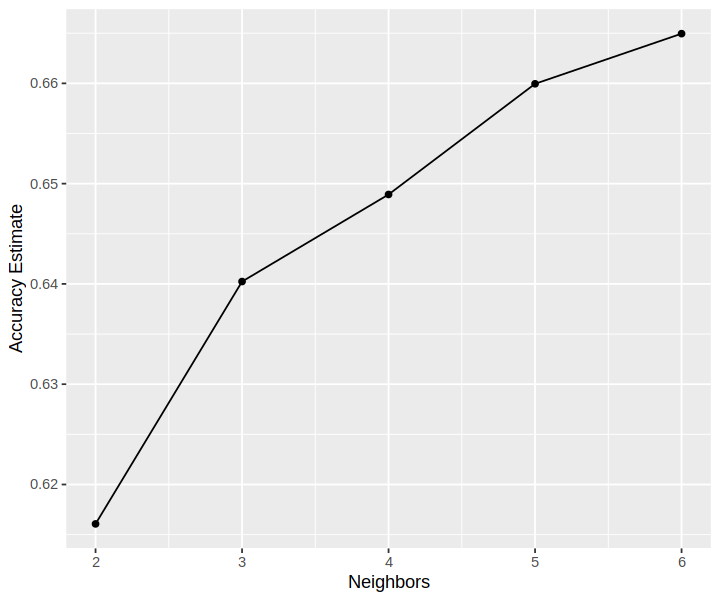

In [6]:
#step 1, 5-fold cross validation
options(repr.plot.height = 5, repr.plot.width = 6)
basket_recipe <- recipe(POSTSEASON ~ ADJOE+ADJDE+ORB+`3P_O`+ADJ_T+TOR+G+W , data = cbb_train)
basket_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

basket_vfold <- vfold_cv(cbb_train, v = 5, strata = POSTSEASON)

basket_workflow <- workflow() |>
      add_recipe(basket_recipe) |>
      add_model(basket_spec)

k_vals <- tibble(neighbors = seq(2,6))

basket_results <- basket_workflow|>
                        tune_grid(resamples = basket_vfold, grid = k_vals)|>
                        collect_metrics()

accuracies <- basket_results|> filter(.metric == "accuracy")

cross_val_plot <- accuracies|>ggplot(aes(x = neighbors, y=mean)) + 
                                geom_point()+
                                geom_line()+
                                labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot